In [397]:
%matplotlib inline

import os
import sys
import time

import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
from skimage import measure
from skimage import transform
from scipy import ndimage
from matplotlib import pyplot as plt
import tensorflow as tf

import util
import image_aug
import luna_util
import luna_cropper
import luna_preprocess
import luna_enhance
import luna_unet_data1
import luna_train_unet1
import luna_unet_data2
import luna_train_unet2
import luna_unet_data3

reload(util);
reload(image_aug);
reload(luna_util);
reload(luna_cropper);
reload(luna_preprocess);
reload(luna_enhance);
reload(luna_unet_data1);
reload(luna_train_unet1);
reload(luna_unet_data2);
reload(luna_train_unet2);
reload(luna_unet_data3);

In [369]:
x, y = luna_unet_data3.load_data(['subset0', 'subset1', 'subset2'])

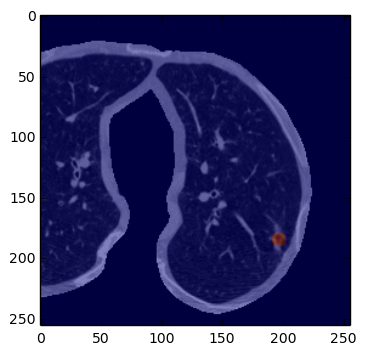

In [386]:
idx = np.random.randint(len(x))
plot_image_and_mask(x[idx,0], y[idx,0])

In [469]:
def sample_with_min_num_nodules(min_num_nodules, annt_df, subset):
    if subset is not None:
        annt_df = annt_df[annt_df.file.str.contains(subset)]
    t = annt_df.groupby('file').count()
    t = list(t[t.seriesuid>=min_num_nodules].index)
    f = t[np.random.randint(len(t))]
    f_id = luna_preprocess.get_file_id(f)
    return f_id, annt_df[annt_df.file==f]
    

def plot_image_and_mask(image, mask):
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.5)

    
def rand_slice_image(masked_lung, all_nodule_mask):
    image, mask = luna_util.slice_image(
        masked_lung, all_nodule_mask, np.random.randint(len(masked_lung)))
    return luna_unet_data1._transform(image, mask)[0:2]


def slice_image_with_nodule(masked_lung, all_nodule_mask, nodule):
    nod_v_x, nod_v_y, nod_v_z, nod_v_d = nodule
    image, mask = luna_util.slice_image(
        masked_lung, all_nodule_mask, nod_v_z)    
    return luna_unet_data1._transform(image, mask)[0:2]


def pred_nodule_mask(image, model):
    ans = np.zeros_like(image)
    for i in range(5):
        for j in range(5):
            row_slice = slice(i * 96, (i + 1) * 96)
            col_slice = slice(j * 96, (j + 1) * 96)
            image_patch = np.reshape(image[row_slice, col_slice], [1, 1, 96, 96])
            image_patch = luna_train_unet2.normalize_images(image_patch)
            mask_patch = model.predict(image_patch)[0,0]
            ans[row_slice, col_slice] = mask_patch
    return ans

def pred_nodule_mask_v2(image, model):
    ans = np.zeros_like(image)
    for i in range(18):
        for j in range(18):
            row_slice = slice(24 * i, 24 * i + 96)
            col_slice = slice(24 * j, 24 * j + 96)
            image_patch = np.reshape(image[row_slice, col_slice], [1, 1, 96, 96])
            image_patch = luna_train_unet2.normalize_images(image_patch)
            mask_patch = model.predict(image_patch)[0,0]
            ans[row_slice, col_slice] += mask_patch
    return ans / 4.0

In [388]:
file_list = luna_preprocess.get_file_list()
file_dict = luna_preprocess.get_file_dict(file_list)
annt_df = luna_preprocess.get_annt_df(file_dict)

with tf.device('/cpu:0'):
    model = luna_train_unet2.get_unet()
# model.load_weights('./unet2.hdf5')
# model.load_weights('./unet2.hdf5-gpu-epoch-16-0p77')
model.load_weights('./unet2.hdf5-gpu-epoch-66-0p91')

In [389]:
f_id, f_annt = sample_with_min_num_nodules(5, annt_df, 'subset0')
print f_id

1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663


0


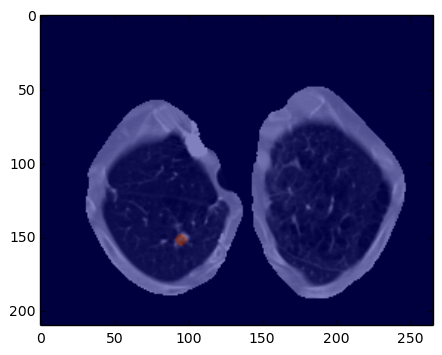

In [390]:
f_id, f_annt = sample_with_min_num_nodules(1, annt_df, 'subset0')
# f_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227'
# f_id = '1.3.6.1.4.1.14519.5.2.1.6279.6001.892375496445736188832556446335'
image = luna_preprocess.Image()
image.load(f_id)
masked_lung = image.masked_lung
all_nodule_mask = image._all_nodule_mask
nodules = image.get_v_nodules()
nod_idx = np.random.randint(len(nodules))
print nod_idx
t_image, t_nodule_mask = slice_image_with_nodule(
    masked_lung, all_nodule_mask, nodules[nod_idx])
plot_image_and_mask(t_image, t_nodule_mask)

In [394]:
image = luna_preprocess.Image()
image.load(f_id)
masked_lung = image.masked_lung
all_nodule_mask = image._all_nodule_mask
nodules = image.get_v_nodules()
print '# of nodules = %d'%len(nodules)

# of nodules = 1


In [470]:
t_image, t_nodule_mask = slice_image_with_nodule(
    masked_lung, all_nodule_mask, nodules[0])
p_nodule_mask = pred_nodule_mask_v2(t_image, model)
print luna_train_unet2.dice_coef_np(t_nodule_mask, p_nodule_mask)

0.421975221511


In [401]:
t_image, t_nodule_mask = rand_slice_image(masked_lung, all_nodule_mask)
p_nodule_mask = pred_nodule_mask(t_image, model)
print luna_train_unet2.dice_coef_np(t_nodule_mask, p_nodule_mask)

0.387453311661


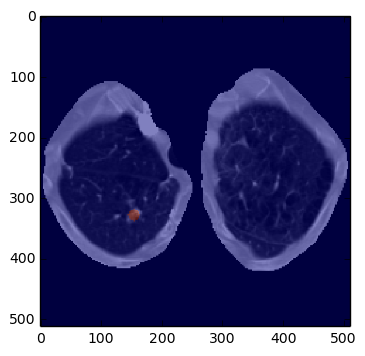

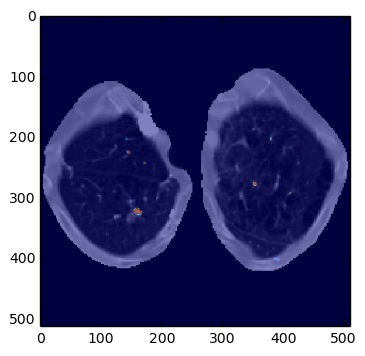

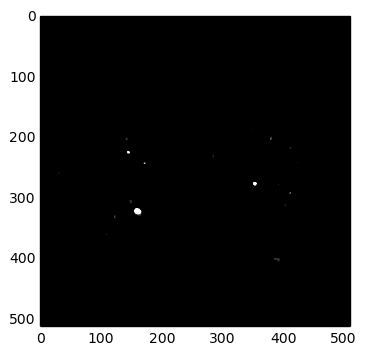

In [471]:
plt.figure()
plot_image_and_mask(t_image, t_nodule_mask)
plt.figure()
plot_image_and_mask(t_image, p_nodule_mask)
plt.figure()
plt.imshow(p_nodule_mask, cmap='gray')